# Homework 3: Semantic Retrieval, Text Clustering, and IR Evaluation

In the following are my results for the 3rd Homework Assignement for Information Retrieval and Web Search.
The notebook is divided into 4 parts:
        0. Utility Functions
        1. Latent Semantic Indexing
        2. Text Clustering
        3. IR Evaluation
        4. Semantic Retrieval and Word Embeddings 

In [1]:
from pprint import pprint
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
import math
import seaborn as sns; sns.set()
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
%matplotlib inline

# 0. Utilility Functions

In [2]:
def preprocess_query(query):
    """Preprocessing of the corpus, filter for nouns and adjectives and lemmatize"""
    # stop = set(stopwords.words('english'))
    tags = {'NN', 'NNS', 'NNP', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS'}
    wordnet_lemmatizer = WordNetLemmatizer()
    # for i in range(len(query)):
    query = [(word.lower(), convert(tag)) for (word, tag) in nltk.pos_tag(nltk.word_tokenize(query)) if tag in tags]
    query = [wordnet_lemmatizer.lemmatize(w, t) for (w, t) in query ]
    return query

def preprocess(docs):
    """Preprocessing of the corpus, filter for nouns and adjectives and lemmatize"""
    # stop = set(stopwords.words('english'))
    tags = {'NN', 'NNS', 'NNP', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS'}
    for i in range(len(docs)):
        docs[i] = [(word.lower(), convert(tag)) for (word, tag) in nltk.pos_tag(nltk.word_tokenize(docs[i])) if tag in tags]
    return lemmatize_docs(docs)

def lemmatize_docs(docs):
    """Lemmatize the terms of the corpus"""
    wordnet_lemmatizer = WordNetLemmatizer()
    for i in range(len(docs)):
        docs[i] = [wordnet_lemmatizer.lemmatize(w, t) for (w, t) in docs[i]]
    return docs

def convert(tag):
    """Convert tag from treebank to wordnet format"""
    if is_noun(tag):
        return wn.NOUN
    if is_adjective(tag):
        return wn.ADJ
    
def is_noun(tag):
    """True if tag corresponds to treebank noun tags"""
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']

def is_adjective(tag):
    """True if tag corresponds to treebank adjective tags"""
    return tag in ['JJ', 'JJR', 'JJS']

# 1. Latent Semantic Indexing

In [3]:
d1 = """Frodo and Sam were trembling in the darkness, surrounded in darkness by hundreds of blood-
thirsty orc. Sam was certain these beast were about to taste the scent of their flesh."""

d2 = """The faceless black beast then stabbed Frodo. He felt like every nerve in his body was hurting.
Suddenly, he thought of Sam and his calming smile. Frodo had betrayed him."""

d3 = """Frodo’s sword was radiating blue, stronger and stronger every second. Orc were getting
closer. And these weren’t just regular orc either, Uruk-Hai were among them. Frodo had
killed regular orc before, but he had never stabbed an Uruk-Hai, not with the blue stick."""

d4 = """Sam was carrying a small lamp, shedding some blue light. He was afraid that orc might
spot him, but it was the only way to avoid deadly pitfalls of Mordor."""

docs = [d1, d2, d3, d4]
docs = preprocess(docs)

In [4]:
def preprocess(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for i in range(len(docs)):
        docs[i] = [word.lower() for word in tokenizer.tokenize(docs[i])]
    return docs

#### a)
Your vocabulary consists of the following terms: Frodo, Sam, beast, orc, and blue.
Compute the TF-IDF term-document occurrence matrix for given document collection and
vocabulary terms.

In [5]:
def calcTFIDF(docs):
    tf = calcTF(terms, docs)
    idf = calcIDF(terms, docs)
    return np.multiply(idf, tf)

def calcTF(docs):
    tf = np.zeros((len(terms), len(docs)))
    for i in range(0, len(docs)):
        for j in range(0, len(terms)):
            tf[j][i] = docs[i].count(terms[j])
    return tf

def calcIDF(docs):
    doc_count = len(docs)
    idf = np.zeros((len(terms),len(terms)))
    for j in range(0, len(terms)):
        term_count = 0
        for i in range(0, len(docs)):
            if terms[j] in docs[i]:
                term_count += 1
            idf[j][j] = doc_count / term_count  if term_count > 0 else 0
    return idf

In [6]:
terms = ["Frodo", "Sam", "beast","orc", "blue"]
terms = [t.lower() for t in terms]
idf = calcIDF(docs)
pprint(idf)
tf  = calcTF(docs)
pprint(tf)
tfidf = np.transpose(np.matmul(np.transpose(tf), idf))
pprint(tfidf)

array([[ 1.33333333,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.33333333,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  2.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.33333333,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  2.        ]])
array([[ 1.,  2.,  2.,  0.],
       [ 2.,  1.,  0.,  1.],
       [ 1.,  1.,  0.,  0.],
       [ 1.,  0.,  3.,  1.],
       [ 0.,  0.,  2.,  1.]])
array([[ 1.33333333,  2.66666667,  2.66666667,  0.        ],
       [ 2.66666667,  1.33333333,  0.        ,  1.33333333],
       [ 2.        ,  2.        ,  0.        ,  0.        ],
       [ 1.33333333,  0.        ,  4.        ,  1.33333333],
       [ 0.        ,  0.        ,  4.        ,  2.        ]])


#### b)
Perform the singular value decomposition of the above matrix and write down
the obtained factor matrices U, Σ, and V. You can use some existing programming library
to perform the SVD (e.g., numpy.linalg.svd in Python).

In [7]:
u, sigma, v = np.linalg.svd(tfidf)
pprint([u, sigma, v])

[array([[ -4.85279372e-01,  -3.20298863e-01,  -7.05471070e-01,
          9.51352972e-02,  -3.93919299e-01],
       [ -2.41792427e-01,  -5.50491549e-01,   6.63994195e-01,
          2.05997018e-01,  -3.93919299e-01],
       [ -1.75793034e-01,  -5.83892823e-01,  -6.20129059e-02,
         -6.02554933e-02,   7.87838597e-01],
       [ -5.98256394e-01,   2.34463181e-01,   2.05534526e-01,
         -7.38154362e-01,   3.05311332e-16],
       [ -5.63228595e-01,   4.45492851e-01,   1.23823405e-01,
          6.32464953e-01,   2.62612866e-01]]),
 array([ 7.08256944,  4.34281253,  2.12423778,  0.82886997]),
 array([[-0.34466026, -0.27787293, -0.83868126, -0.31719029],
       [-0.6332787 , -0.63458983,  0.42960496,  0.10813604],
       [ 0.46136234, -0.52722742, -0.26542436,  0.66236391],
       [-0.51702242,  0.49205043, -0.20396868,  0.67005296]])]


#### c)
Reduce the rank of the factor matrices to K = 2, i.e., compute the 2-dimensional
vectors for vocabulary terms and documents. Show terms and documents as points in a
2-dimensional graph.

In [8]:
u_2 = u[:,0:2]
sigma_2 = np.diag(sigma[0:2])
v_2 = np.transpose(v[:,0:2])
dense_vector = np.matmul(sigma_2, v_2)

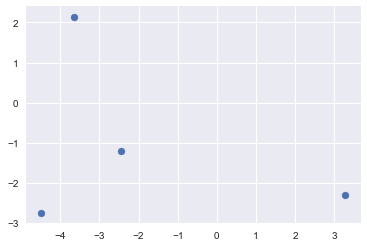

In [9]:
x = dense_vector[:1,:]
y = dense_vector[1:2,:]
plt.scatter(x,y)
plt.show()

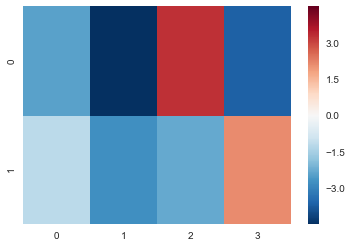

In [10]:
sns.heatmap(dense_vector)

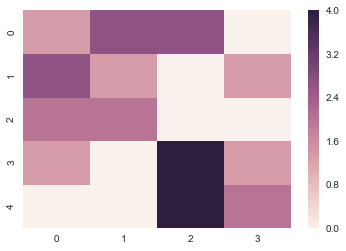

In [11]:
sns.heatmap(tfidf)

#### d)
You are given the query “Sam blue orc”. Compute the latent vector for the query
and rank the documents according to similarity of their latent vectors with the obtained
latent vector of the query.

In [39]:
# def calc_cos_sim(vec1, vec2):
#     dotproduct = 0
#     logx = 0
#     logy = 0
#     if len(vec1) != len(vec2):
#         raise ValueError('Vectors have different length')
#     for i in range(0, len(vec1)):
#         dotproduct += vec1[i] * vec2[i]
#         logx += vec1[i]**2
#         logy += vec2[i]**2
#     return dotproduct / (logx * logy)

def cosinesim(vec1, vec2):
    if len(vec1) != len(vec2):
        raise ValueError('Vectors have different length')
    numerator = sum([vec1[x] * vec2[x] for x in range(0, len(vec1))])
    sum1 = sum([vec1[x]**2 for x in range(0,len(vec1))])
    sum2 = sum([vec2[x]**2 for x in range(0,len(vec2))])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator
                   
def calc_similarities(query, docs, sim, k = len(docs)):
    ranking = []
    i = 0
    for doc in docs:
        doc_score = {'doc': i+1,
              'similarity': sim(query, doc)}
        i += 1
        ranking.append(doc_score)
    return sorted(ranking, key=lambda x:x['similarity'], reverse=True)[:k]

In [13]:
query = ["Sam", "blue", "orc"]
query = [t.lower() for t in query]

tf_query = np.transpose(calcTF([query]))
tfidf_query = np.transpose(np.matmul(tf_query, np.transpose(idf)))
print("Sparse Query TF-IDF Vector")
pprint(tfidf_query)
print("Query Vector in Latent Space")
dense_query = np.matmul(np.transpose(u_2), tfidf_query)
pprint(dense_query)

pprint(calc_similarities(np.transpose(dense_query)[0], np.transpose(dense_vector), cosinesim))

Sparse Query TF-IDF Vector
array([[ 0.        ],
       [ 1.33333333],
       [ 0.        ],
       [ 1.33333333],
       [ 2.        ]])
Query Vector in Latent Space
array([[-2.24652228],
       [ 0.46961454]])
[{'doc': 4, 'similarity': 0.948552064568377},
 {'doc': 1, 'similarity': 0.7867987390042477},
 {'doc': 2, 'similarity': 0.7268708588672939},
 {'doc': 3, 'similarity': -0.9190524718049762}]


# 2. Text Clustering 

In [14]:
d1 = [0.17, 0.21, 0.35, 0.44, 0.49, 0.39, 0.09, 0.07, 0.37, 0.24]
d2 = [0.49, 0.48, 0.44, 0.09, 0.24, 0.2, 0.41, 0.16, 0.1, 0.15]
d3 = [0.41, 0.36, 0.27, 0.19, 0.15, 0.42, 0.23, 0.42, 0.02, 0.42]
d4 = [0.31, 0.41, 0.21, 0.19, 0.47, 0.28, 0.21, 0.39, 0.16, 0.38]
d5 = [0.46, 0.12, 0.21, 0.25, 0.38, 0.38, 0.46, 0.23, 0.31, 0.14]
d6 = [0.13, 0.33, 0.28, 0.42, 0.07, 0.13, 0.58, 0.15, 0.0, 0.49]
d7 = [0.21, 0.09, 0.07, 0.09, 0.3, 0.54, 0.24, 0.43, 0.51, 0.21]
d8 = [0.18, 0.39, 0.42, 0.05, 0.41, 0.1, 0.52, 0.12, 0.14, 0.38]
d9 = [0.4, 0.51, 0.01, 0.1, 0.12, 0.22, 0.26, 0.34, 0.42, 0.38]
docs = [d1, d2, d3, d4, d5, d6, d7, d8, d9]

#### a)
Assume that a news outlet is sequentially streaming these documents, from d 1
to d 9 . 

Cluster the documents using the single pass clustering (SPC) algorithm based
on cosine similarity between the given TF-IDF document vectors.

Run the SPC using different values for similarity threshold: 

(i) λ = 0.6, (ii) λ = 0.8. 

What is the difference between the two clusterings, using different values for λ? 

Next, cluster the documents with SPC assuming the opposite order of streaming, from d 9 to d 1 (use λ = 0.8). 

Did you obtain the same clusters as before?

In [15]:
def singlepassclustering(docs, lambdax):
    clusters = {}
    result = {}
    clusters[0] = []
    result[0] = []
    clusters[0].append(docs[0])
    result[0].append(1)
    cluster_count = 0
    for i in range(1, len(docs)):
        cluster_sim = {}
        for c in range(0, len(clusters)):
            cluster_sim[c] = simDocCluster(docs[i], clusters[c])
        x = max(cluster_sim.keys(), key=(lambda key: cluster_sim[key]))
        if(cluster_sim[x] > lambdax):
            clusters[x].append(docs[i])
            result[x].append(i+1)
        else:
            cluster_count +=1
            clusters[cluster_count] = []
            clusters[cluster_count].append(docs[i])
            result[cluster_count] = []
            result[cluster_count].append(i+1)
    return result

def simDocCluster(doc, cluster):
    similarities = 0.0
    for c in cluster:
        similarities += cosinesim(doc, c)
    return similarities / len(cluster)            

def cosinesim(doc1, doc2):
    numerator = sum([doc1[x] * doc2[x] for x in range(0, len(doc1))])
    sum1 = sum([doc1[x]**2 for x in range(0,len(doc1))])
    sum2 = sum([doc2[x]**2 for x in range(0,len(doc2))])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [16]:
lambda1 = 0.6
lambda2 = 0.8
lambda3 = 0.8
spc1 = singlepassclustering(docs, lambda1)
spc2 = singlepassclustering(docs, lambda2)
docs_reversed = docs[::-1]
spc3 = singlepassclustering(docs_reversed, lambda3)

print("(i)")
pprint(spc1)
print("(ii)")
pprint(spc2)
print("(iii)")
pprint(spc3)


(i)
{0: [1, 2, 3, 4, 5, 6, 7, 8, 9]}
(ii)
{0: [1], 1: [2, 3, 4, 5, 9], 2: [6, 8], 3: [7]}
(iii)
{0: [1, 3, 5, 6, 7], 1: [2, 4, 8], 2: [9]}


#### b)
Cluster the above given documents using the k-means algorithm, with K = 3
and using the following initial centroids:

r1 = [0.33, 0.33, 0.42, 0.12, 0.2, 0.34, 0.58, 0.19, 0.07, 0.24]

r2 = [0.29, 0.16, 0.38, 0.48, 0.43, 0.11, 0.12, 0.33, 0.03, 0.44]

r3 = [0.01, 0.17, 0.11, 0.27, 0.23, 0.37, 0.35, 0.48, 0.54, 0.24].

Use the cosine similarity between document vectors and centroids to guide the clustering.b

In [17]:
r1 = [0.33, 0.33, 0.42, 0.12, 0.2, 0.34, 0.58, 0.19, 0.07, 0.24]
r2 = [0.29, 0.16, 0.38, 0.48, 0.43, 0.11, 0.12, 0.33, 0.03, 0.44]
r3 = [0.01, 0.17, 0.11, 0.27, 0.23, 0.37, 0.35, 0.48, 0.54, 0.24]
centroids = np.array((r1,r2,r3))
kmeans = KMeans(n_clusters=3, random_state=0, init=centroids).fit(docs)
pprint(kmeans.labels_)

array([1, 0, 0, 1, 0, 0, 2, 0, 2])


E:\DevelopmentTools\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


#### Results
Cluster 0 = d2, d4, d5, d7, d8 

Cluster 1 = d6, d9

Cluster 2 = d1, d3, 

# 3. IR Evaluation

In [18]:
r1 = set(['d1', 'd2', 'd5', 'd6', 'd13'])
r2 = set(['d1', 'd2', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd19', 'd14', 'd17', 'd3', 'd15', 'd16', 'd18', 'd20'])
r3 = set(['d1', 'd2', 'd4', 'd5', 'd9', 'd10', 'd12', 'd13', 'd14', 'd15', 'd20'])
relevant = set(['d1','d3','d5','d7','d9','d11', 'd13', 'd15', 'd17', 'd19'])

#### a)
Compute the precision, recall and F 1 score for each of the three IR systems.

What is the downside of using precision, recall, and F measure to evaluate IR systems?

For some query q all odd documents are considered to be relevant and all documents with even identifiers are considered not relevant.

precision = tp / (tp + fp)

recall = tp / (tp + fn)

f-measure = 2 * (precision * recall) / (precision + recall)

In [19]:
def calc_measures(retrieved, relevant):
    def calc_precision():
        tp = len(set.intersection(retrieved, relevant))
        return tp/len(retrieved)
    
    precision = calc_precision()
    
    def calc_recall():
        tp = len(set.intersection(retrieved, relevant))
        return tp/len(relevant)
    
    recall = calc_recall()
    
    def calc_f1():
        return (2 * precision * recall) / (precision + recall)
        
    return (calc_precision(), calc_recall(), calc_f1())

In [20]:
(p, r, f) = calc_measures(r1, relevant)
print("IR System 1: 'Precision': " + str(p) + " 'Recall': " + str(r) + " 'F1': " + str(f))
(p, r, f) = calc_measures(r2, relevant)
print("IR System 2: 'Precision': " + str(p) + " 'Recall': " + str(r) + " 'F1': " + str(f))
(p, r, f) = calc_measures(r3, relevant)
print("IR System 3: 'Precision': " + str(p) + " 'Recall': " + str(r) + " 'F1': " + str(f))

IR System 1: 'Precision': 0.6 'Recall': 0.3 'F1': 0.4
IR System 2: 'Precision': 0.5 'Recall': 1.0 'F1': 0.6666666666666666
IR System 3: 'Precision': 0.45454545454545453 'Recall': 0.5 'F1': 0.47619047619047616


#### b)
Compute the precision at rank 5 (P@5), R-precision, and average precision (AP)
for each of the three IR systems.

In [21]:
print("IR System 1")

pat5_1 = 3 / (3 + 2)
print("P@5: " + str(pat5_1))
r_precision_1 = 2 / (2 + 1)
print("R-precision [R@3]: " + str(r_precision_1))
ap_1 = (1 / 3) * ((1/1)+(2/3)+(3/5))
print("Average Precision: " + str(ap_1))

print()

print("IR System 2")

pat5_2 = 2 / (2 + 3)
print("P@5: " + str(pat5_2))
r_precision_2 = 4 / (4 + 6)
print("R-precision [R@10]: " + str(r_precision_2))
ap_2 = (1 / 10) * ((1/1)+(2/4)+(3/6)+(4/8)+(5/10)+(6/12)+(7/13)+(9/15)+(10/17))  
print("Average Precision: " + str(ap_2))

print()

print("IR System 3")

pat5_3 = 3 / (3 + 2)
print("P@5: " + str(pat5_3))
r_precision_3 = 3 / (3 + 2)
print("R-precision [R@5]: " + str(r_precision_3))
ap_3 = (1/5)*((1/1)+(2/4)+(3/5)+(4/8)+(5/10))
print("Average Precision: " + str(ap_3))


IR System 1
P@5: 0.6
R-precision [R@3]: 0.6666666666666666
Average Precision: 0.7555555555555555

IR System 2
P@5: 0.4
R-precision [R@10]: 0.4
Average Precision: 0.5226696832579185

IR System 3
P@5: 0.6
R-precision [R@5]: 0.6
Average Precision: 0.6200000000000001


#### c)
You are given a toy IR system which is being evaluated on five queries.

The following are the positions of relevant documents for each of these five queries, in the rankings returned by the toy IR system:

• q 1 → [1, 6, 9, 17, 21]

• q 2 → [1, 3, 4]

• q 3 → [2, 5, 8, 9, 10]

• q 4 → [4]

• q 5 → [1, 2, 6]

Evaluate the performance of this IR system in terms of mean average precision.

In [22]:
precision_q1 = (1/4) * ((1/1)+(2/3)+(3/4)+(4/5))
precision_q2 = (1/2) * ((1/1)+(2/2))
precision_q3 = (1/2) * ((1/2)+(2/4))
precision_q4 = 0
precision_q5 = (1/1) * (1/1)

MAP = (1/5) * (precision_q1 + precision_q2 + precision_q3 + precision_q3 + precision_q4 + precision_q5)
print("MAP: " + str(MAP))

MAP: 0.7608333333333334


# 4. Semantic Retrieval with Word Embeddings

### Load Newsgroup dataset

In [23]:
from sklearn.datasets import fetch_20newsgroups
newsgroup_data = fetch_20newsgroups(remove=('headers', 'footers'))
# remove docs with less than 5 words
for doc in newsgroup_data.data:
    if len(doc) < 5:
        newsgroup_data.data.remove(doc)
# selecting 500 random articles
np.random.seed(1337)
newsgroup_articles = np.random.choice(newsgroup_data.data, 500, False)

### Load Word Embeddings

In [24]:
with open("./embeddings/glove.6B.50d.txt", "r", encoding='utf8') as lines:
    embeddings_vec = {}
    for line in lines:
        embeddings_vec[str(line.split()[0])] = line.split()[1:]

### Preprocessing

In [25]:
STOPWORDS = stopwords.words('english')
def corpus_preprocessing(docs):
#   """Tokenize documents and remove stopwords"""
    tokenizer = RegexpTokenizer(r'\w+')
    processed = []
    for i in range(len(docs)):
        processed.append([word.lower() for word in tokenizer.tokenize(docs[i]) if word not in STOPWORDS])
    return processed

### Create TF-IDF for each document

In [26]:
def docs_idf(docs):
    """Computes the IDF for a collection of Documents"""
    docs_count = len(docs)
    idf = {}
    for doc in docs:
        for term in doc:
            if term in idf:
                idf[term] += 1
            else:
                idf[term] = 1
    for k,v in idf.items():
        idf[k] = docs_count / v
    return idf

def doc_tf(doc):
    """Computes the TF for a Document"""
    tf = {}
    for term in doc:
        if term not in tf:
            tf[term] = doc.count(term)
    return tf

def doc_tfidf(doc, idf):
    """Computes the TF-IDF for each document of a collection"""
    tfidf = {}
    tf = doc_tf(doc)
    for term, tf in tf.items():
        tfidf[term] = idf[term] * tf
    return tfidf
    

In [27]:
newsgroup_articles_processed = corpus_preprocessing(newsgroup_articles)
nap_idf = docs_idf(newsgroup_articles_processed)
nap_tfidf = [doc_tfidf(doc, nap_idf) for doc in newsgroup_articles_processed]

### Calculate Embedding Vector

In [35]:
from IPython.core.debugger import set_trace
def calc_document_embedding_vec(doc, word_embeddings):
    """Calculates the embedding vector for a given document and embeddings vector"""
    matches = set(doc.keys()).intersection(set(word_embeddings.keys()))
    doc_vec = {}
    nominator = 0
    denominator = 0
    for term in matches:
        term_idf = doc[term]
        term_w2v = sum([float(embedding) for embedding in word_embeddings[term]])
        nominator += term_idf * term_w2v
        denominator += term_idf
        doc_vec[term] = nominator / denominator
    return doc_vec

In [41]:
def cosinesim_diff(vec1, vec2):
    dotproduct = 0
    sum1 = 0
    sum2 = 0
    for term in set.union(set(vec1), set(vec2)):
        c1 = vec1.get(term, 0)
        c2 = vec2.get(term, 0)
        sum1 += c1**2
        sum2 += c2**2
        dotproduct += c1 * c2
    return dotproduct / (math.sqrt(sum1) + math.sqrt(sum2))

In [40]:
newsgroup_embeddings = [calc_document_embedding_vec(doc, embeddings_vec) for doc in nap_tfidf]

In [42]:
query = ["Hello World"]
query = corpus_preprocessing(query)
query_tfidf = doc_tfidf(query[0], nap_idf)
query_embedding = calc_document_embedding_vec(query_tfidf, embeddings_vec)
ranking_embedded = calc_similarities(query=query_embedding, docs=newsgroup_embeddings, sim=cosinesim_diff, k=10)
pprint(ranking_embedded)

[{'doc': 241, 'similarity': 0.09820105548394405},
 {'doc': 186, 'similarity': 0.09730761997967266},
 {'doc': 79, 'similarity': 0.08282667940949827},
 {'doc': 483, 'similarity': 0.07101421257559107},
 {'doc': 226, 'similarity': 0.034921365483137234},
 {'doc': 53, 'similarity': 0.03439517315239352},
 {'doc': 492, 'similarity': 0.031403798728340364},
 {'doc': 199, 'similarity': 0.030631675409969326},
 {'doc': 16, 'similarity': 0.027333314235764468},
 {'doc': 64, 'similarity': 0.027244578001592183}]
